In [1]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc

%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage0
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.basemap import addcyclic
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from matplotlib.lines import Line2D
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
seas='JJA'
reg='IPCC'
nyear=1
rebasing=False

if (seas == "DJF"):
    sind=1
else:
    sind=0

print(sind)
def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        # print(tmp)
        # print(tmp.shape)
        # print(dates)
        tmp['year']=dates
#         print(tmp.year)
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    # print(dsnew)
    return(dsnew)

def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas):
    season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
    seasindex=season[seas]
    if (seas == 'ann'):
        var_seas=var.groupby('time.year').mean('time')
    else:
        if (var.ndim == 4):
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time') #rename({"time":"year"})
        elif (var.ndim == 3): 
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        print(var_seas)
    return(var_seas)

zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)
# print(zipgmst)
def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)


gmststab=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc')))
gmst=xr.open_mfdataset(gmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
gmst=rebase(gmst,gmststab)
gmstbase=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/gmst/tas_gmst_*.nc'))
gmstref=xr.open_mfdataset(gmstbase,combine='nested',concat_dim='cases')['tas']
base=gmstref[:,0:50].mean('cases').mean('year')
gmst2=gmst-base

    # calculate transient_gmst 

gmstssp=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/gmst/tas_gmst_*.nc'))
gmstsspt=xr.open_mfdataset(gmstssp,combine='nested',concat_dim='cases')['tas']
gmstssp370=gmstsspt-base

0
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bu607.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_fi

In [3]:
seas='JJA'
scenario='ssp370'
var='pr'
lentrend=500 # length of trend - use 500 for Fig 2 in paper
stable={}
transient={}
stable_r={}
stable['pr']=rebase(xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable_land.nc')['pr_region_mean'],"")[:,0:lentrend].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
print(stable['pr'].shape)
transient['pr']=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_'+scenario+'_land.nc')['pr_region_mean'].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
print(stable['pr'].shape)
print(transient['pr'].shape)
region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable_land.nc')['names'].values


(6, 46)
(6, 46)
(16, 46)


In [4]:
def check_sign_agreement(input):
    pos_neg=np.where((input > 0)&(~np.isnan(input)), 1.0, -1.0)
    # Calculate the sum of positive values
    sum_positive = np.sum(pos_neg[pos_neg > 0])

    # Calculate the sum of negative values
    sum_negative = np.sum(pos_neg[pos_neg < 0])
    n_agree=np.max([sum_positive,np.abs(sum_negative)])
    return(n_agree)

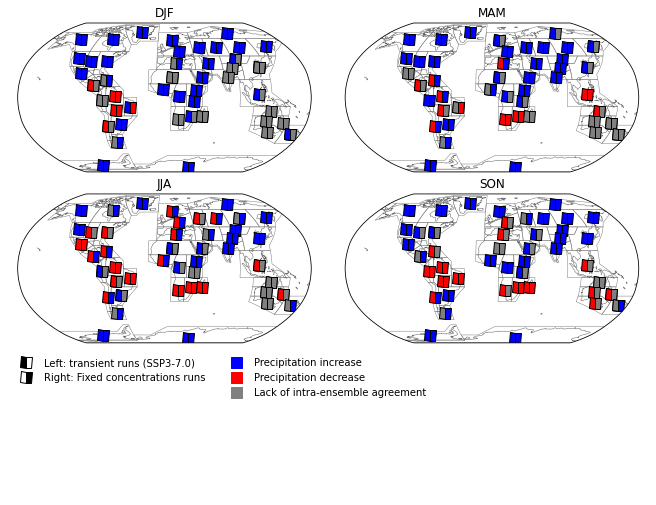

In [5]:
reg='IPCC'
seas=['DJF','MAM','JJA','SON'] #'DJF','MAM','JJA','SON']
# print(center[1])
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

f, axarr = plt.subplots(nrows=3, ncols=2,figsize=(9, 2.3*3), constrained_layout=True,subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr.flatten()
# ax.coastlines(color="black",alpha=1)
# mask = regionmask.defined_regions.ar6.land.mask(lon, lat)
s=0
for seas in seas:
    ax[s].set_global()
    regionmask.defined_regions.ar6.land.plot(
    ax=ax[s], add_label=False, line_kws=dict(lw=0.5, color="gray",zorder=1)
)
    stable=rebase(xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['pr_region_mean'],"")[:,0:lentrend].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    transient=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_transient.nc')['pr_region_mean'].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['names'].values

    for r in np.arange(0,46):
        center=regionmask.defined_regions.ar6.land.centroids[r]
        # print(check_sign_agreement(stable[:,r]))
        if (((check_sign_agreement(stable[:,r]) >= 5.)) and ((check_sign_agreement(transient[:,r]) >= 13.))):
            if ((np.mean(transient,axis=0)[r] > 0) and (np.mean(stable,axis=0)[r] > 0)):  
                # print('yes')
                test,=ax[s].plot(center[0],center[1],marker="s",linestyle='',c='blue',markerfacecoloralt='blue',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
            elif ((np.mean(transient,axis=0)[r] < 0) and (np.mean(stable,axis=0)[r] < 0)):   
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='red',markerfacecoloralt='red',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
            elif ((np.mean(transient,axis=0)[r] < 0) and (np.mean(stable,axis=0)[r] > 0)):   
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='red',markerfacecoloralt='blue',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
            elif ((np.mean(transient,axis=0)[r] > 0) and (np.mean(stable,axis=0)[r] < 0)):   
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='blue',markerfacecoloralt='red',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
# stable is robust but not transient
        if ((np.abs((check_sign_agreement(stable[:,r]) >= 5.))) and (np.abs((check_sign_agreement(transient[:,r]) <= 13.)))):
            if (np.mean(stable,axis=0)[r] > 0):   
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='gray',markerfacecoloralt='blue',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
            elif (np.mean(stable,axis=0)[r] < 0):
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='gray',markerfacecoloralt='red',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2)
# transient is robust but not stable
        if ((np.abs((check_sign_agreement(stable[:,r]) <= 5.))) and (np.abs((check_sign_agreement(transient[:,r]) >= 13.)))):
            if (np.mean(transient,axis=0)[r] > 0):   
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='blue',markerfacecoloralt='gray',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)            elif (np.mean(stable,axis=0)[r] < 0):
            elif (np.mean(transient,axis=0)[r] < 0):
                ax[s].plot(center[0],center[1],marker="s",linestyle='',c='red',markerfacecoloralt='gray',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)            elif (np.mean(stable,axis=0)[r] < 0):
        if ((np.abs((check_sign_agreement(stable[:,r]) <= 5.))) and (np.abs((check_sign_agreement(transient[:,r]) <= 13.)))):
            ax[s].plot(center[0],center[1],marker="s",linestyle='',c='gray',markerfacecoloralt='gray',fillstyle='left',markersize=11,linewidth=2,markeredgecolor='black',transform=ccrs.PlateCarree(),zorder=2) #,label=lab)            elif (np.mean(stable,axis=0)[r] < 0):
    ax[s].set_title(seas)
    s=s+1


    
gs = ax[4].get_gridspec()
for ax in ax[4:]:
    ax.remove()
axbig = f.add_subplot(gs[4:])
axbig.axis('off')
# Create legend items with rectangles
legend_items = [
    Line2D([0], [0], marker='s',linestyle='',c='black',markerfacecoloralt='w',fillstyle='left',linewidth=0.5,markeredgecolor='black', markersize=11),
    Line2D([0], [0], marker='s',linestyle='',c='w',markerfacecoloralt='black',fillstyle='left',linewidth=0.5,markeredgecolor='black', markersize=11),
    Line2D([0], [0], marker='s',linestyle='',c='w',alpha=0),
    Line2D([0], [0], marker='s',linestyle='',c='blue', markersize=11),
    Line2D([0], [0], marker='s',linestyle='',c='red', markersize=11),
    Line2D([0], [0], marker='s',linestyle='',c='gray', markersize=11),
]

# Create a custom legend with rectangles and text
custom_legend = axbig.legend(legend_items, ['Precipitation increase', 'Precipitation decrease', 'Lack of intra-ensemble agreement', 'Text Legend 1', 'Text Legend 2'], title='', loc='upper left', bbox_to_anchor=(1, 1))

# Create a custom legend with rectangles
custom_legend = axbig.legend(legend_items, ['Left: transient runs (SSP3-7.0)','Right: Fixed concentrations runs',"",'Precipitation increase', 'Precipitation decrease','Lack of intra-ensemble agreement'], title='', loc=2, ncol = 2, frameon=False) #, bbox_to_anchor=(1, 1))

plt.savefig('summary_figure_precip_'+str(lentrend)+'.png',dpi=300)